### DeepFashion

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import cv2
from tqdm import tqdm
import shutil

In [5]:
dense_mapping= {
    0:  "bg",

    # torso & face
    1:  "torso_skin",   #Does not include neck
    2:  "torso_skin",   #Does not include neck
    23: "face",
    24: "face",

    # hands
    3:  "R_hand",
    4:  "L_hand",

    # feet
    5:  "R_foot",
    6:  "L_foot",

    # upper legs (thighs) & lower legs (calves)
    7:  "R_leg",   # right thigh (one of the two charts)
    9:  "R_leg",
    8:  "L_leg",   # left thigh
    10: "L_leg",
    11: "R_leg",   # right calf
    13: "R_leg",
    12: "L_leg",   # left calf
    14: "L_leg",

    # upper arms & forearms (inside/outside charts collapsed)
    15: "L_arm",   # left upper arm (inside/outside)
    17: "L_arm",
    16: "R_arm",   # right upper arm
    18: "R_arm",
    19: "L_arm",   # left forearm
    21: "L_arm",
    20: "R_arm",   # right forearm
    22: "R_arm",
}

segm_classes = {
  0: 'Bkg',
  1: 'Top',
  2: 'Outer',
  3: 'Skirt',
  4: 'Dress',
  5: 'Pants',
  6: 'Leggings',
  7: 'Headwear',
  8: 'Eyeglass',
  9: 'Neckwear',
  10: 'Belt',
  11: 'Footwear',
  12: 'Bag',
  13: 'Hair',
  14: 'Face',
  15: 'Skin',
  16: 'Ring',
  17: 'Wrist wearing',
  18: 'Socks',
  19: 'Gloves',
  20: 'Necklace',
  21: 'Rompers',
  22: 'Earrings',
  23: 'Tie'
}

lip_merged_classes = {
  0: 'Bkg',
  1: 'Upper-Face',
  2: 'Face',
  3: 'Arm',
  4: 'Leg',
  5: 'Upper-clothes',
  6: 'One-piece',
  7: 'Lower-clothes',
  8: 'Shoe'
}


In [ ]:
### Mapping LIP Merged without Torso

dense_to_merged = {
    0 : 0,           #Bkg        -> Bkg
    1 : 0,           #Torso-skin -> Bkg  #TODO Confirm
    2 : 0,           #Torso-skin -> Bkg  #TODO Confirm
    3 : 3,           #R_hand     -> Arm
    4 : 3,           #L_hand     -> Arm
    5 : 4,           #R_foot     -> Leg  (Same as in LIP)
    6 : 4,           #L_foot     -> Leg  (Same as in LIP)
    7 : 4,           #Leg parts  -> Leg
    8 : 4,           
    9 : 4,
    10: 4,
    11: 4,
    12: 4,
    13: 4,
    14: 4,
    15: 3,          #Arm parts  -> Arm
    16: 3,
    17: 3,
    18: 3,
    19: 3,
    20: 3,
    21: 3,
    22: 3,
    23: 2,          #Face parts -> Face (Includes neck)
    24: 2
}

segm_to_merged = { #deepfashion_to_lip_merged:
  0 : 0,   #Bkg      -> Bkg
  1 : 5,   #Top      -> Upper-clothes
  2 : 5,   #Outer    -> Upper-clothes
  3 : 7,   #Skirt    -> Lower-clothes
  4 : 6,   #Dress    -> One-piece
  5 : 7,   #Pants    -> Lower-clothes
  6 : 7,   #Leggings -> Lower-clothes
  7 : 1,   #Headwear -> Upper-Face
  8 : 2,   #Eyeglass -> Face
  9 : 2,   #Neckwear -> Face             #TODO Unsure
  10: 7,   #Belt     -> Lower-clothes
  11: 8,   #Footwear -> Shoe
  12: 0,   #Bag      -> Background
  13: 1,   #Hair     -> Upper-face
  14: 2,   #Face     -> Face
  15: 15,  #Skin     -> Skin            #TODO: Skin Distinct Mapping
  16: 3,   #Ring     -> Arm
  17: 3,   #Wrist..  -> Arm
  18: 4,   #Socks    -> Leg
  19: 3,   #Gloves   -> Arm
  20: 2,   #Necklace -> Face             #TODO Unsure
  21: 6,   #Rompers  -> One-piece
  22: 2,   #Earrings -> Face             #TODO Unsure
  23: 5    #Tie      -> Upper-clothes
}

segm_to_merged_lookup = np.arange(24)
for k, v in segm_to_merged.items():
    segm_to_merged_lookup[k] = v

In [ ]:
### Mapping LIP Merged including Torso

dense_to_merged = {
    0 : 0,           #Bkg        -> Bkg
    1 : 3,           #Torso-skin -> Arm  #TODO Confirm
    2 : 3,           #Torso-skin -> Arm  #TODO Confirm
    3 : 3,           #R_hand     -> Arm
    4 : 3,           #L_hand     -> Arm
    5 : 4,           #R_foot     -> Leg  (Same as in LIP)
    6 : 4,           #L_foot     -> Leg  (Same as in LIP)
    7 : 4,           #Leg parts  -> Leg
    8 : 4,           
    9 : 4,
    10: 4,
    11: 4,
    12: 4,
    13: 4,
    14: 4,
    15: 3,          #Arm parts  -> Arm
    16: 3,
    17: 3,
    18: 3,
    19: 3,
    20: 3,
    21: 3,
    22: 3,
    23: 2,          #Face parts -> Face (Includes neck)
    24: 2
}

segm_to_merged = { #deepfashion_to_lip_merged:
  0 : 0,   #Bkg      -> Bkg
  1 : 5,   #Top      -> Upper-clothes
  2 : 5,   #Outer    -> Upper-clothes
  3 : 7,   #Skirt    -> Lower-clothes
  4 : 6,   #Dress    -> One-piece
  5 : 7,   #Pants    -> Lower-clothes
  6 : 7,   #Leggings -> Lower-clothes
  7 : 1,   #Headwear -> Upper-Face
  8 : 2,   #Eyeglass -> Face
  9 : 2,   #Neckwear -> Face             #TODO Unsure
  10: 7,   #Belt     -> Lower-clothes
  11: 8,   #Footwear -> Shoe
  12: 0,   #Bag      -> Background
  13: 1,   #Hair     -> Upper-face
  14: 2,   #Face     -> Face
  15: 15,  #Skin     -> Skin            #TODO: Skin Distinct Mapping
  16: 3,   #Ring     -> Arm
  17: 3,   #Wrist..  -> Arm
  18: 4,   #Socks    -> Leg
  19: 3,   #Gloves   -> Arm
  20: 2,   #Necklace -> Face             #TODO Unsure
  21: 6,   #Rompers  -> One-piece
  22: 2,   #Earrings -> Face             #TODO Unsure
  23: 5    #Tie      -> Upper-clothes
}

segm_to_merged_lookup = np.arange(24)
for k, v in segm_to_merged.items():
    segm_to_merged_lookup[k] = v

In [23]:
### Mapping LIP Merged including Torso, separate hands and upper body, and feet and lower body

dense_to_merged = {
    0 : 0,           #Bkg        -> Bkg
    1 : 5,           #Torso-skin -> Upper-Clothes  #TODO Confirm
    2 : 5,           #Torso-skin -> Upper-Clothes  #TODO Confirm
    3 : 3,           #R_hand     -> Arm
    4 : 3,           #L_hand     -> Arm
    5 : 4,           #R_foot     -> Leg  (Same as in LIP)
    6 : 4,           #L_foot     -> Leg  (Same as in LIP)
    7 : 7,           #Leg parts  -> Lower clothes
    8 : 7,           
    9 : 7,
    10: 7,
    11: 7,
    12: 7,
    13: 7,
    14: 7,
    15: 5,          #Arm parts  -> Upper-Clothes
    16: 5,
    17: 5,
    18: 5,
    19: 5,
    20: 5,
    21: 5,
    22: 5,
    23: 2,          #Face parts -> Face (Includes neck)
    24: 2
}

segm_to_merged = { #deepfashion_to_lip_merged:
  0 : 0,   #Bkg      -> Bkg
  1 : 5,   #Top      -> Upper-clothes
  2 : 5,   #Outer    -> Upper-clothes
  3 : 7,   #Skirt    -> Lower-clothes
  4 : 6,   #Dress    -> One-piece
  5 : 7,   #Pants    -> Lower-clothes
  6 : 7,   #Leggings -> Lower-clothes
  7 : 1,   #Headwear -> Upper-Face
  8 : 2,   #Eyeglass -> Face
  9 : 2,   #Neckwear -> Face             #TODO Unsure
  10: 7,   #Belt     -> Lower-clothes
  11: 8,   #Footwear -> Shoe
  12: 0,   #Bag      -> Background
  13: 1,   #Hair     -> Upper-face
  14: 2,   #Face     -> Face
  15: 15,  #Skin     -> Skin            #TODO: Skin Distinct Mapping
  16: 3,   #Ring     -> Arm
  17: 5,   #Wrist..  -> Upper Clothes   #TODO CHANGED
  18: 7,   #Socks    -> Lower Clothes   #TODO CHANGED
  19: 3,   #Gloves   -> Arm
  20: 2,   #Necklace -> Face             #TODO Unsure
  21: 6,   #Rompers  -> One-piece
  22: 2,   #Earrings -> Face             #TODO Unsure
  23: 5    #Tie      -> Upper-clothes
}

segm_to_merged_lookup = np.arange(24)
for k, v in segm_to_merged.items():
    segm_to_merged_lookup[k] = v

#### Filter Images, Segms, Keypoints

In [ ]:
dir_path = 'Datasets/DeepFashion'

im_dir = os.path.join(dir_path, 'images')
segm_dir = os.path.join(dir_path, 'segm')
keypts_dir = os.path.join(dir_path, 'keypoints')
dense_dir = os.path.join(dir_path, 'densepose')

id = 'WOMEN-Tees_Tanks-id_00005085-31_4_full'

In [ ]:
os.listdir(dense_dir)[0]

In [ ]:
#Filter data to only segm imgs

valid_ids = [f.replace("_segm.png", "") for f in os.listdir(segm_dir)]
print(f"Valid IDs: {len(valid_ids)}")

dest_dir = os.path.join(dir_path, "filt")
dest_im_dir = os.path.join(dest_dir, "images")
dest_segm_dir = os.path.join(dest_dir, "segm")
dest_keypts_dir = os.path.join(dest_dir, "keypoints")
dest_dense_dir = os.path.join(dest_dir, "densepose")

os.makedirs(dest_im_dir, exist_ok=True)
os.makedirs(dest_segm_dir, exist_ok=True)
os.makedirs(dest_keypts_dir, exist_ok=True)
os.makedirs(dest_dense_dir, exist_ok=True)

#Copy valid imgs, segms 
for id in tqdm(valid_ids):

    im_id = id + ".jpg"
    segm_id = id + "_segm.png"
    dense_id = id + "_densepose.png"

    source_im_path = os.path.join(im_dir, im_id)
    dest_im_path = os.path.join(dest_im_dir, im_id)

    source_segm_path = os.path.join(segm_dir, segm_id)
    dest_segm_path = os.path.join(dest_segm_dir, segm_id)

    source_dense_path = os.path.join(dense_dir, dense_id)
    dest_dense_path = os.path.join(dest_dense_dir, dense_id)

    # shutil.copy(source_im_path, dest_im_path)
    # shutil.copy(source_segm_path, dest_segm_path)
    # shutil.copy(source_dense_path, dest_dense_path)

In [ ]:
#Copy valid keypoints

def open_txt(path):

    with open(path, "r") as f:
        info = f.readlines()

    info = [row.strip() for row in info]
    return info

keypts_loc_path = os.path.join(keypts_dir, "keypoints_loc.txt")
keypts_vis_path = os.path.join(keypts_dir, "keypoints_vis.txt")

keypts_loc = open_txt(keypts_loc_path)
keypts_vis = open_txt(keypts_vis_path)

dest_keypts_loc_path = os.path.join(dest_keypts_dir, "keypoints_loc.txt")
dest_keypts_vis_path = os.path.join(dest_keypts_dir, "keypoints_vis.txt")

# for loc in keypts_loc:
#     id = loc.split(" ")[0].replace(".jpg", "")

#     with open(dest_keypts_loc_path, "a") as f:
#         f.write(loc + '\n')

# for vis in keypts_vis:
#     id = vis.split(" ")[0].replace(".jpg", "")

#     with open(dest_keypts_vis_path, "a") as f:
#         f.write(vis + '\n')

#### Read Data

In [9]:
dir_path = 'Datasets/DeepFashion/filt'

im_dir = os.path.join(dir_path, 'images')
segm_dir = os.path.join(dir_path, 'segm')
keypts_dir = os.path.join(dir_path, 'keypoints')
dense_dir = os.path.join(dir_path, 'densepose')

ids = [f.replace(".jpg", "") for f in os.listdir(im_dir)]

id = 'WOMEN-Tees_Tanks-id_00005085-31_4_full'
id = 'WOMEN-Dresses-id_00001124-04_4_full'
# id = np.random.choice(ids)
id

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/DeepFashion/filt/images'

In [ ]:
im_path = os.path.join(im_dir, f"{id}.jpg")
im = np.array(Image.open(im_path))

segm_path = os.path.join(segm_dir, f"{id}_segm.png")
segm = np.array(Image.open(segm_path))

dense_path = os.path.join(dense_dir, f"{id}_densepose.png")
dense = np.array(Image.open(dense_path))[:, :, 2]

fig, ax = plt.subplots(1, 3, figsize = (10, 5))

for i, plot_im in enumerate([im, segm, dense]):
    ax[i].imshow(plot_im)
    ax[i].set_axis_off()

In [ ]:
np.unique(dense[:, :, 2])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5))

dense_id = 24

im_path = os.path.join(im_dir, f"{id}.jpg")
im = np.array(Image.open(im_path))

plot_0 = im
plot_1 = dense[:, :, 2]
plot_2 = dense[:, :, 2] == dense_id
print(f"Dense Part: {dense_mapping[dense_id]}")

plots = [plot_0, plot_1, plot_2]

for i in range(3):
    ax[i].imshow(plots[i])
    ax[i].set_axis_off()

#### Mapping Skin Segm

In [30]:
dir_path = 'data/DeepFashion_Multi'

# im_dir = os.path.join(dir_path, 'DeepFashion_LIP/train_images')
# segm_dir = os.path.join(dir_path, 'DeepFashion_LIP/train_segmentations')

im_dir = os.path.join(dir_path, 'DeepFashion_LIP/val_images')
segm_dir = os.path.join(dir_path, 'DeepFashion_LIP/val_segmentations')

dense_dir = os.path.join(dir_path, 'densepose')

ids = [f.replace(".jpg", "") for f in os.listdir(im_dir)]

id = 'WOMEN-Tees_Tanks-id_00005085-31_4_full'
# id = 'WOMEN-Dresses-id_00001124-04_4_full'
# id = 'WOMEN-Skirts-id_00006463-07_7_additional'
# id = 'WOMEN-Blouses_Shirts-id_00002630-01_4_full'
# id = 'WOMEN-Tees_Tanks-id_00002157-05_4_full'
# id = 'MEN-Shorts-id_00005151-06_4_full'
# id = np.random.choice(ids)
id

'WOMEN-Tees_Tanks-id_00005085-31_4_full'

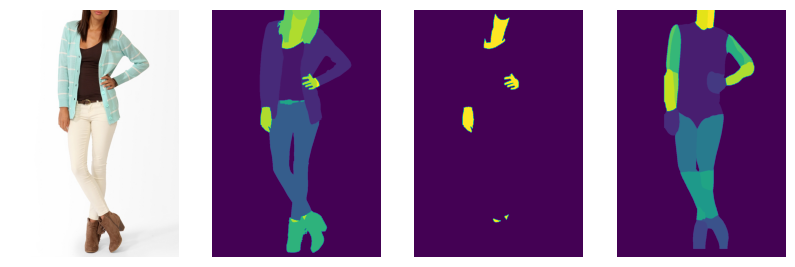

In [31]:
im_path = os.path.join(im_dir, f"{id}.jpg")
im = np.array(Image.open(im_path))

segm_path = os.path.join(segm_dir, f"{id}_segm.png")
segm = np.array(Image.open(segm_path))

skin = segm == 15

dense_path = os.path.join(dense_dir, f"{id}_densepose.png")
dense = np.array(Image.open(dense_path))[:, :, 2]

fig, ax = plt.subplots(1, 4, figsize = (10, 5))

for i, plot_im in enumerate([im, segm, skin, dense]):
    ax[i].imshow(plot_im)
    ax[i].set_axis_off()

##### Pipeline

In [26]:
import numpy as np
from skimage.segmentation import expand_labels

In [43]:
def get_lookup(mapping):

    lookup = np.arange(len(mapping))
    for k, v in mapping.items():
        lookup[k] = v

    return lookup

def DeepFashion_mapping(segm, dense, 
                        segm_map_lookup, dense_map_lookup,
                        skin_label=15, expand_px=10):
    
    #Mapping
    segm_mapped = segm_map_lookup[segm]
    dense_mapped = dense_map_lookup[dense]

    #Mapping skin to distinct labels
    segm_skin = (segm == skin_label)
    dense_mapped_expand = expand_labels(dense_mapped, distance=expand_px)

    skin_distinct = np.where(segm_skin, dense_mapped_expand, 0)
    
    #Merge the result with segmentation
    result = np.where(segm_mapped == 15, skin_distinct, segm_mapped)
    return result


In [44]:
segm_map_lookup = get_lookup(segm_to_merged)
dense_map_lookup = get_lookup(dense_to_merged)

segm_result = DeepFashion_mapping(segm, dense,
                                  segm_map_lookup, dense_map_lookup)

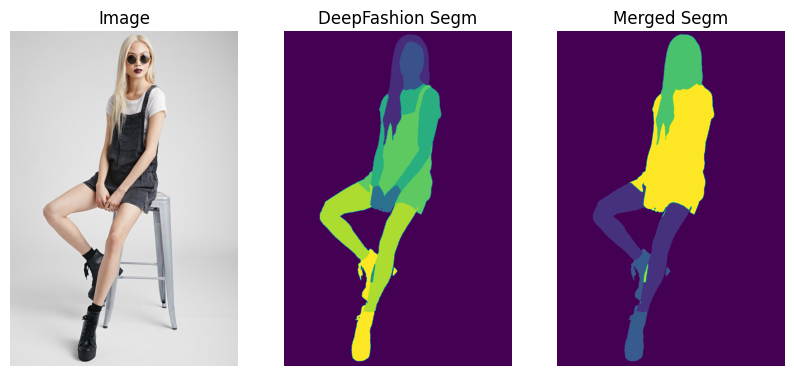

In [45]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5))

plots = [im, segm, segm_result]
titles = ["Image", "DeepFashion Segm", "Merged Segm"]

for i in range(len(plots)):
    ax[i].imshow(plots[i])
    ax[i].set_axis_off()
    ax[i].set_title(titles[i])

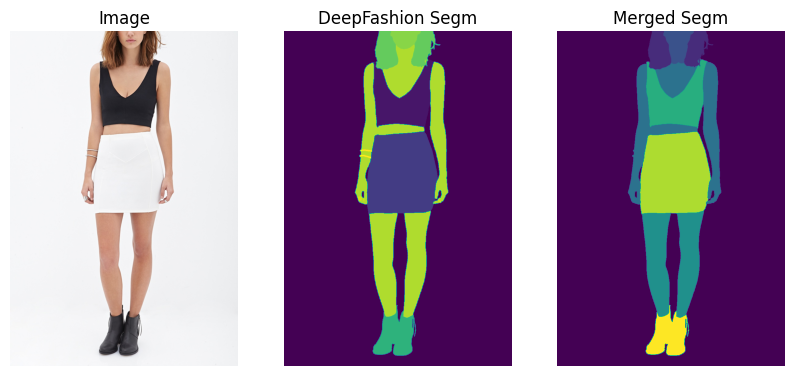

In [30]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5))

plots = [im, segm, segm_result]
titles = ["Image", "DeepFashion Segm", "Merged Segm"]

for i in range(len(plots)):
    ax[i].imshow(plots[i])
    ax[i].set_axis_off()
    ax[i].set_title(titles[i])

##### Rough

In [114]:
segm = segm_to_merged_lookup[segm]

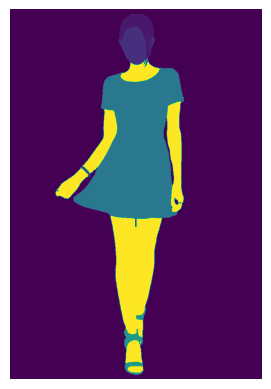

In [115]:
fig, ax = plt.subplots()

ax.imshow(segm)
ax.set_axis_off()

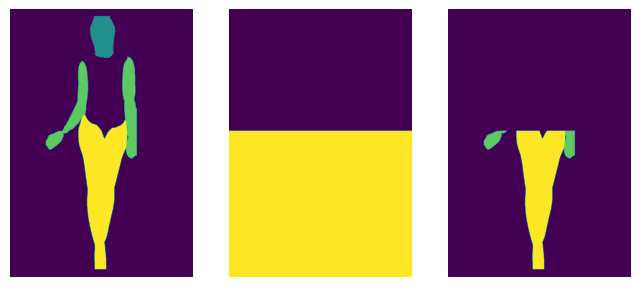

In [116]:
mapping_lookup = np.arange(25)
for k, v in dense_to_merged.items():
    mapping_lookup[k] = v

dense_merged = mapping_lookup[dense]

mask = np.zeros_like(dense_merged)
mask[500:, :] = 1

masked = np.where(mask, dense_merged, 0)

fig, ax = plt.subplots(1, 3, figsize = (8, 5))

plots = [dense_merged, mask, masked]

for i in range(len(plots)):
    ax[i].imshow(plots[i])
    ax[i].set_axis_off()

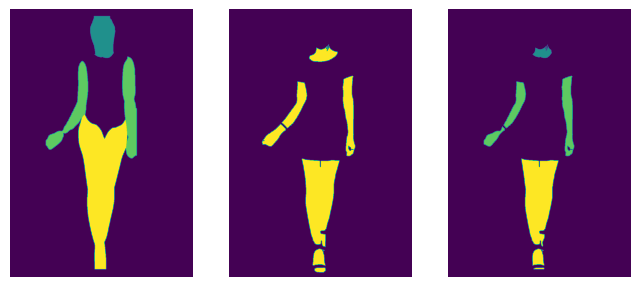

In [117]:
mapping_lookup = np.arange(25)
for k, v in dense_to_merged.items():
    mapping_lookup[k] = v

dense_merged = mapping_lookup[dense]

skin = segm == 15
mask = skin

masked = np.where(skin, dense_merged, 0)

fig, ax = plt.subplots(1, 3, figsize = (8, 5))

plots = [dense_merged, mask, masked]

for i in range(len(plots)):
    ax[i].imshow(plots[i])
    ax[i].set_axis_off()

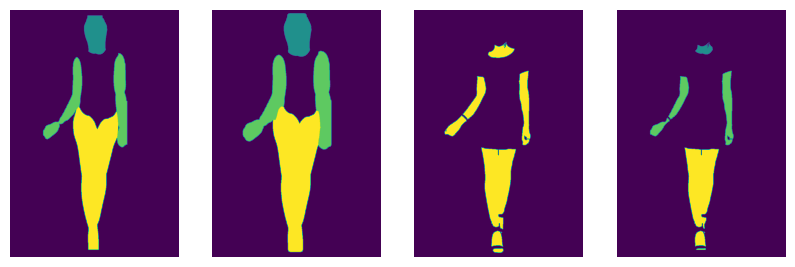

In [118]:
import numpy as np
from skimage.segmentation import expand_labels

mapping_lookup = np.arange(25)
for k, v in dense_to_merged.items():
    mapping_lookup[k] = v

dense_merged = mapping_lookup[dense]
dense_merged_expand = expand_labels(dense_merged, distance = 10)

skin = segm == 15
mask = skin

# masked = np.where(skin, dense_merged_expand, 0)
masked = np.where(skin, dense_merged, 0)

fig, ax = plt.subplots(1, 4, figsize = (10, 5))

plots = [dense_merged, dense_merged_expand, mask, masked]

for i in range(len(plots)):
    ax[i].imshow(plots[i])
    ax[i].set_axis_off()

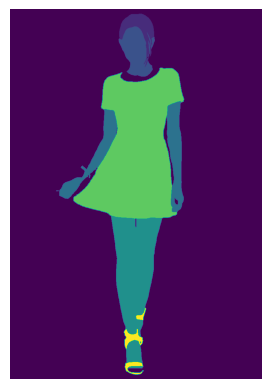

In [119]:
segm_check = segm.copy()

segm_check = np.where(segm_check == 15, masked, segm_check)

fig, ax = plt.subplots()
ax.imshow(segm_check)
ax.set_axis_off()

[0 1]
[0 1]
[0 1]


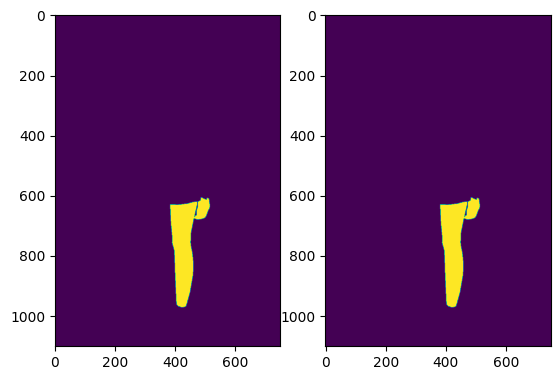

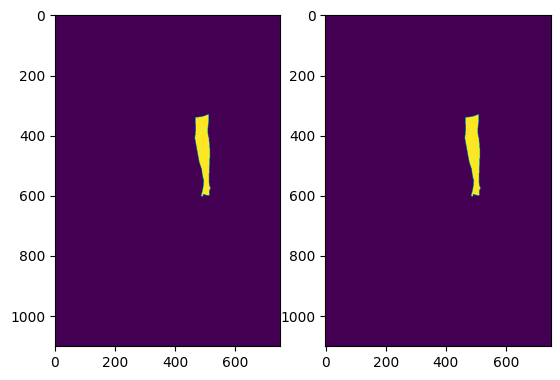

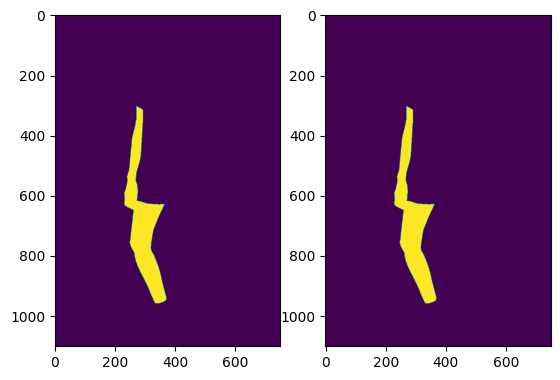

In [43]:
#Iterate through Contours and check if assignment is valid
skin_diff = masked.astype("uint8")
skin_diff[skin_diff > 0] = 1

skin = skin.astype("uint8")

skin_diff_cnts, _ = cv2.findContours(
    skin_diff,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

skin_cnts, _ = cv2.findContours(
    skin,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

count = -1
for skin_diff_cnt, skin_cnt in zip(skin_diff_cnts, skin_cnts):
    count += 1

    # if count != 4: 
    #     continue

    skin_diff_cnt_mask = np.zeros_like(skin_diff)
    skin_cnt_mask = np.zeros_like(skin)

    cv2.drawContours(skin_diff_cnt_mask, [skin_diff_cnt], contourIdx=-1, color=1, thickness=-1)
    cv2.drawContours(skin_cnt_mask, [skin_cnt], contourIdx=-1, color=1, thickness=-1)

    skin_diff_masked = np.where(skin_diff_cnt_mask, skin_diff, 0)
    print(np.unique(skin_diff_masked))

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(skin_diff_cnt_mask)
    ax[1].imshow(skin_cnt_mask)

[3 4]
[3]
[3 4]
[-1, 3, -1]


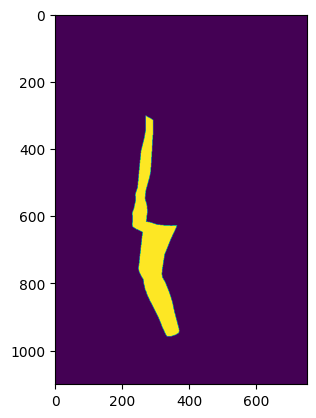

In [44]:
#Assign labels to contours
skin = skin.astype("uint8")

skin_cnts, _ = cv2.findContours(
    skin.astype("uint8"),
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

cnt_labels = []

for cnt in skin_cnts:

    cnt_mask = np.zeros_like(skin)
    cv2.drawContours(cnt_mask, [cnt], contourIdx=-1, color=15, thickness=-1)


    plt.imshow(cnt_mask)

    cnt_with_dense = np.where(cnt_mask, dense_merged, 0)
    all_labels = np.unique(cnt_with_dense)
    all_labels = all_labels[all_labels > 0]
    print(all_labels)

    if len(all_labels) == 1:
        cnt_labels.append(int(all_labels[0]))
    elif len(all_labels) == 0:
        continue
    else:
        cnt_labels.append(-1)


print(cnt_labels)

-1
3
-1


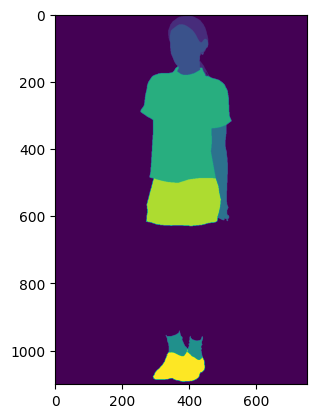

In [45]:
segm_cnt = segm.copy()
segm_cnt = segm_cnt.astype("uint8")

for label, cnt in zip(cnt_labels, skin_cnts):
    print(label)
    cv2.drawContours(segm_cnt, [cnt], contourIdx=-1, color=label, thickness=-1)

plt.imshow(segm_cnt)

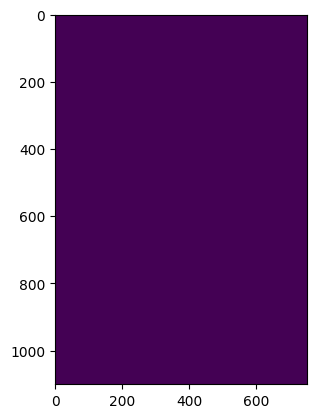

In [46]:
plt.imshow(segm_cnt == 15)

### Delete Unnecessary Data

In [8]:
import os
import shutil
from tqdm import tqdm

In [2]:
source_dir = "data/DeepFashion_Multi"

densepose_dir = os.path.join(source_dir, "densepose")
images_dir = os.path.join(source_dir, "images")
segm_dir = os.path.join(source_dir, "segm")

dir_files = lambda path : len(os.listdir(path))

print(dir_files(densepose_dir), dir_files(images_dir), dir_files(segm_dir))

44096 44096 12701


In [4]:
valid_ids = [f.replace("_segm.png", "") for f in os.listdir(segm_dir)]
valid_ids[:5]

['WOMEN-Sweaters-id_00005720-05_1_front',
 'WOMEN-Skirts-id_00007517-02_1_front',
 'WOMEN-Cardigans-id_00002121-11_4_full',
 'WOMEN-Blouses_Shirts-id_00004960-02_4_full',
 'WOMEN-Denim-id_00003347-06_1_front']

In [10]:
get_id_from_img = lambda s: s.replace(".jpg", "")

total_ids = [get_id_from_img(f) for f in os.listdir(images_dir)]
invalid_ids = [id for id in total_ids if id not in valid_ids]
len(invalid_ids)

31395

In [ ]:
for id in tqdm(invalid_ids):

    densepose_path = os.path.join(densepose_dir, f"{id}_densepose.png")
    images_path = os.path.join(images_dir, f"{id}.jpg")

    # os.remove(densepose_path)
    # os.remove(images_path)

100%|██████████| 31395/31395 [00:02<00:00, 12728.79it/s]


### Creating Mapped DeepFashion Dataset

In [35]:
from tqdm import tqdm
import numpy as np
import os

In [ ]:
source_dir = 'data/DeepFashion_Multi'
# source_dir = 'data'

# dest_dir = 'data/DeepFashion_Multi/DeepFashion_merged'
# dest_dir = 'data/DeepFashion_Multi/DeepFashion_merged_with_torso'
dest_dir = 'data/DeepFashion_Multi/DeepFashion_merged_with_torso_2'
dest_dir = 'data/DeepFashion_Multi/DeepFashion_merged_with_torso_5k'
dest_dir = 'data/DeepFashion_Multi/DeepFashion_merged_sep_2.5k'

#Training Data
# source_im_dir = os.path.join(source_dir, 'train_images')
# source_segm_dir = os.path.join(source_dir, 'train_segmentations')
source_im_dir = os.path.join(source_dir, 'images')
source_segm_dir = os.path.join(source_dir, 'segm')
source_dense_dir = os.path.join(source_dir, 'densepose')

dest_im_dir = os.path.join(dest_dir, 'train_images')
dest_segm_dir = os.path.join(dest_dir, 'train_segmentations')


os.makedirs(dest_im_dir, exist_ok=True)
os.makedirs(dest_segm_dir, exist_ok=True)

In [37]:
#Slicing end formatting
def slice_end(s):

    ignore = [".jpg", "_segm.png"]
    for s_ignore in ignore:
        s = s.replace(s_ignore, "")

    return s

def split_to_train_val_ids(dir_path, num_train, 
                            ignore_dir=None):
    """
    Iterates through the files in a directory, slicing off the format endings, and 
    splits into train-val splits.

    The ignore_dir generates a list of IDs to be ignored.
    """


    #Get ignore IDs
    if ignore_dir:
        ignore_ids = [slice_end(f_ignore) for f_ignore in os.listdir(ignore_dir)]
    else:
        ignore_ids = []
    print(f"Ignore IDs: {len(ignore_ids)}")

    #Valid IDs
    ids = [slice_end(f) for f in os.listdir(dir_path)]
    ids = [id for id in ids if id not in ignore_ids]
    
    #Train-Val split
    train_ids = np.random.choice(ids, num_train, replace=False)
    val_ids = np.random.choice(ids, len(ids) - num_train, replace=False)

    print(f"Split : (Train : {len(train_ids)}, Val : {len(val_ids)})")
    return train_ids, val_ids


In [39]:
#Ignore Data
ignore_dir = 'data/DeepFashion_Multi/DeepFashion_merged_with_torso'
ignore_im_dir = os.path.join(ignore_dir, 'train_images')
ignore_segm_dir = os.path.join(ignore_dir, 'train_segmentations')


#Valid IDs
train_ids, val_ids = split_to_train_val_ids(source_segm_dir, num_train=2500,
                                                ignore_dir = None, #ignore_im_dir
                                                )

Ignore IDs: 0
Split : (Train : 2500, Val : 10201)


In [81]:
train_ids, val_ids = split_to_train_val_ids("data/DeepFashion_Multi/segm",
                                            num_train=0,
                                                ignore_dir = "data/DeepFashion_Multi/DeepFashion_merged_with_torso_5k/train_images"
                                                )

print(len(train_ids), len(val_ids))

Ignore IDs: 5000
Split : (Train : 0, Val : 7701)
0 7701


In [40]:
def move_data(source_root_dir, dest_root_dir,
                segm_map_lookup, dense_map_lookup,
                train_ids=[], val_ids=[]):


    source_im_dir = os.path.join(source_root_dir, "images")
    source_segm_dir = os.path.join(source_root_dir, "segm")
    source_dense_dir = os.path.join(source_root_dir, "densepose")
    assert (os.path.exists(source_im_dir) and \
            os.path.exists(source_segm_dir) and \
            os.path.exists(source_dense_dir))

    for mode in ["train", "val"]:
        print(f"\nMode : {mode}")

        #Initialize the destination dirs
        dest_im_dir = os.path.join(dest_root_dir, f"{mode}_images")
        dest_segm_dir = os.path.join(dest_root_dir, f"{mode}_segmentations")
        os.makedirs(dest_im_dir, exist_ok=True)
        os.makedirs(dest_segm_dir, exist_ok=True)

        #Create the id info file : train_id.txt / val_id.txt
        dest_id_path = os.path.join(dest_root_dir, f"{mode}_id.txt")
        if not os.path.exists(dest_id_path):

            # assert ( (len(train_ids) > 0) and (len(val_ids) > 0) )

            #Define the IDs
            ids = train_ids if mode == "train" else val_ids

            with open(dest_id_path, "w") as f:
                f.write( '\n'.join(ids) + '\n' )
                print(f"Created file : {dest_id_path}")
        
        else:

            with open(dest_id_path, "r") as f:
                ids = f.read().splitlines()
                print(f"Using saved file : {dest_id_path}")


        #Iterate through ids and move the images, segms
        for id in tqdm(ids):

            im_id = f"{id}.jpg"
            segm_id = f"{id}_segm.png"
            dense_id = f"{id}_densepose.png"

            dest_im_path = os.path.join(dest_im_dir, im_id)
            dest_segm_path = os.path.join(dest_segm_dir, segm_id)

            if os.path.exists(dest_im_path) and os.path.exists(dest_segm_path):
                continue
            
            #Extract the image, segm, and densepose
            im_path = os.path.join(source_im_dir, im_id)
            im = np.array(Image.open(im_path))

            segm_path = os.path.join(source_segm_dir, segm_id)
            segm = np.array(Image.open(segm_path))

            dense_path = os.path.join(source_dense_dir, dense_id)
            dense = np.array(Image.open(dense_path))[:, :, 2]

            segm_result = DeepFashion_mapping(segm, dense,
                                            segm_map_lookup, dense_map_lookup)

            #Save Image
            if im.dtype != np.uint8:
                im = (np.clip(im, 0, 1) * 255).round().astype(np.uint8)

            Image.fromarray(im, mode="RGB").save(dest_im_path, quality=95) 

            #Save Segm
            Image.fromarray(segm_result.astype(np.uint8), mode="L").save(dest_segm_path)

In [47]:
segm_to_merged

{0: 0,
 1: 5,
 2: 5,
 3: 7,
 4: 6,
 5: 7,
 6: 7,
 7: 1,
 8: 2,
 9: 2,
 10: 7,
 11: 8,
 12: 0,
 13: 1,
 14: 2,
 15: 15,
 16: 3,
 17: 5,
 18: 7,
 19: 3,
 20: 2,
 21: 6,
 22: 2,
 23: 5}

In [41]:
segm_map_lookup = get_lookup(segm_to_merged)
dense_map_lookup = get_lookup(dense_to_merged)

move_data(source_dir, dest_dir,
            segm_map_lookup, dense_map_lookup,
            train_ids, val_ids)


Mode : train
Created file : data/DeepFashion_Multi/DeepFashion_merged_sep_2.5k/train_id.txt


  0%|          | 0/2500 [00:00<?, ?it/s]/tmp/ipykernel_3158319/412711519.py:72: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(im, mode="RGB").save(dest_im_path, quality=95)
/tmp/ipykernel_3158319/412711519.py:75: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(segm_result.astype(np.uint8), mode="L").save(dest_segm_path)
100%|██████████| 2500/2500 [05:11<00:00,  8.03it/s]



Mode : val
Created file : data/DeepFashion_Multi/DeepFashion_merged_sep_2.5k/val_id.txt


100%|██████████| 10201/10201 [20:03<00:00,  8.47it/s]


In [46]:
dest_dir

'data/DeepFashion_Multi/DeepFashion_merged_sep_2.5k'

[0 1 2 3 5 7 8]


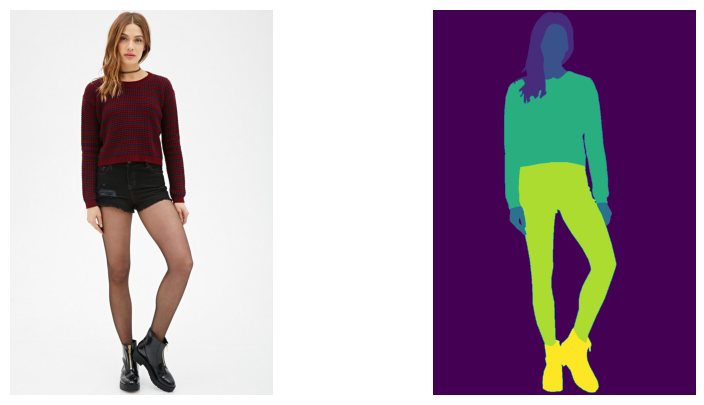

In [58]:
#Test if success
# dir_path = 'data/DeepFashion_Multi/DeepFashion_merged'
# dir_path = 'data/DeepFashion_Multi/DeepFashion_merged_with_torso'

im_dir = os.path.join(dest_dir, 'train_images')
segm_dir = os.path.join(dest_dir, 'train_segmentations')

# im_dir = os.path.join(dir_path, 'val_images')
# segm_dir = os.path.join(dir_path, 'val_segmentations')

ids = [f.replace(".jpg", "") for f in os.listdir(im_dir)]

# id = 'WOMEN-Dresses-id_00002348-07_4_full'
id = np.random.choice(ids)

im_path = os.path.join(im_dir, f"{id}.jpg")
im = np.array(Image.open(im_path))

segm_path = os.path.join(segm_dir, f"{id}_segm.png")
segm = np.array(Image.open(segm_path))

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

for i, plot_im in enumerate([im, segm]):
    ax[i].imshow(plot_im)
    ax[i].set_axis_off()

print(np.unique(segm))

In [14]:
id

'WOMEN-Dresses-id_00002348-07_4_full'

In [35]:
train_id_path = "data/DeepFashion_Multi/DeepFashion_merged/val_id.txt"
data_dir = "/mnt/Self-Correction-Human-Parsing/data/DeepFashion_Multi/DeepFashion_merged"

with open(train_id_path, "r") as f:
    train_ids = f.readlines()

train_ids = [row.strip() for row in train_ids]

not_present = 0
for id in train_ids:

    im_id = id + ".jpg"
    segm_id = id + "_segm.png"

    im_path = os.path.join(data_dir, "val_images", im_id)
    segm_path = os.path.join(data_dir, "val_segmentations", segm_id)

    if not os.path.exists(im_path) or not os.path.exists(segm_path):
        not_present += 1

print(f"Files not present in dir: {not_present}")

Files not present in dir: 0


In [ ]:
import shutil

source_path = os.path.join("data/DeepFashion_Multi/DeepFashion_merged_with_torso", "train_segmentations")

dest_path = os.path.join("data/DeepFashion_Multi/DeepFashion_merged_with_torso_5k", "train_segmentations")
os.makedirs(dest_path, exist_ok=True)

for f in tqdm(os.listdir(source_path)):
    f_source = os.path.join(source_path, f)
    f_dest = os.path.join(dest_path, f)

    # shutil.copy(f_source, f_dest)

100%|██████████| 2500/2500 [00:20<00:00, 119.65it/s]


In [68]:
len(os.listdir(dest_path))

5000

In [59]:
#Slicing end formatting
def slice_end(s):

    ignore = [".jpg", "_segm.png"]
    for s_ignore in ignore:
        s = s.replace(s_ignore, "")

    return s

In [65]:
txt_path = os.path.join(os.path.dirname(dest_path), "train_id.txt")
f_names = [slice_end(f) for f in os.listdir(dest_path)]

with open(txt_path, "w") as f:
    f.write("\n".join(f_names) + "\n")
    

### LIP Dataset

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import cv2
from tqdm import tqdm
import shutil

In [68]:
dir_path = 'data/LIP/'

im_dir = os.path.join(dir_path, 'train_images')
segm_dir = os.path.join(dir_path, 'train_segmentations')

ids = [f.replace(".jpg", "") for f in os.listdir(im_dir)]

id = np.random.choice(ids)
id = '466822_538448'
# id = '474174_455368'
id

'466822_538448'

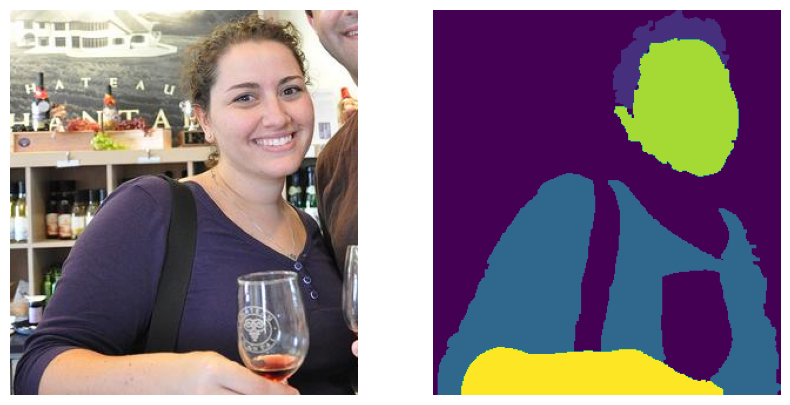

In [69]:
im_path = os.path.join(im_dir, f"{id}.jpg")
im = np.array(Image.open(im_path))

segm_path = os.path.join(segm_dir, f"{id}.png")
segm = np.array(Image.open(segm_path))

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

for i, plot_im in enumerate([im, segm]):
    ax[i].imshow(plot_im)
    ax[i].set_axis_off()